<p style="margin: 100px 0 100px; font-family: Arial; font-size: 50px">
    36E
</p>

In [1]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from statsmodels.stats.weightstats import ztest
from sklearn import cluster as C
from sklearn.decomposition import PCA

flights_path = '../../../datasets/flights.csv'

In [2]:
# Set data on import
def parse_if_str(s):
    try: return str(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

# def parse_ndarray(s):
#     return np.fromstring(s, sep=' ') if s else None

In [3]:
fdf = pd.read_csv(flights_path, converters = {
    'DESTINATION_AIRPORT': parse_if_str,
    'ORIGIN_AIRPORT': parse_if_str})

In [4]:
# dfdf = fdf[fdf["ARRIVAL_DELAY"]>0][['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']].fillna(value=0)
# Hacemos un subset para los registros únicamente con vuelos retrasados en su llegada
dfdf = fdf[fdf["ARRIVAL_DELAY"]>0].fillna(value=0)

# Eliminamos los parámetros de los vuelos cancelados
dfdf.drop(["DIVERTED", "CANCELLED", "CANCELLATION_REASON"], axis=1, inplace=True)

1. ¿Es posible habilitar ahorros al mitigar o eliminar los retrasos en los vuelos?
    - Sí, se muestra un modelo de regresión que busca predecir los retrasos
    
2. ¿El patrón de los retrasos de vuelos está sujeto a periodos de tiempo o es un patrón aleatorio?
    - No, visualizamos los datos con respecto al tiempo para buscar un comportamiento evidente.
    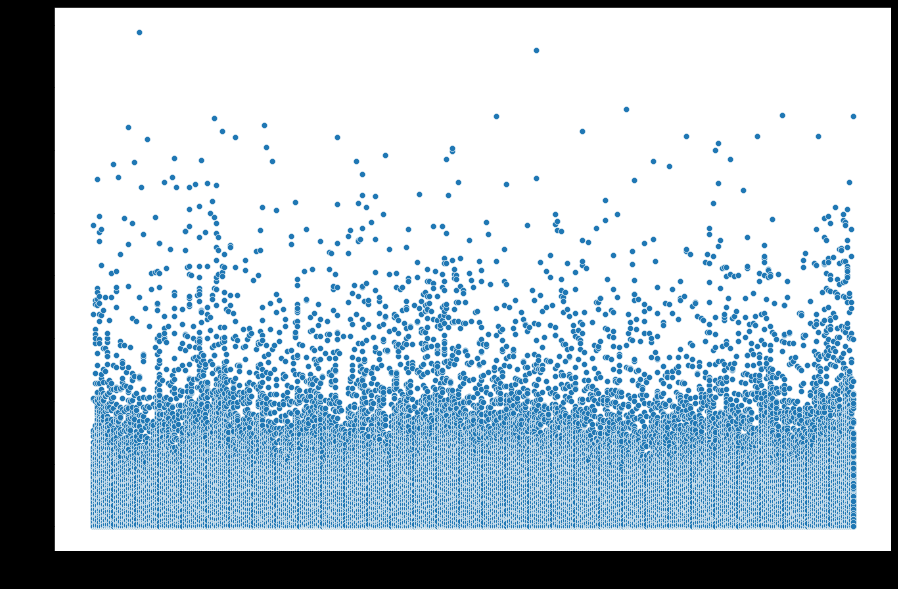
    
    - Utilizamos un modelo de agrupamiento para intentar agrupar por comportamientos (kmeans/dbscan)
    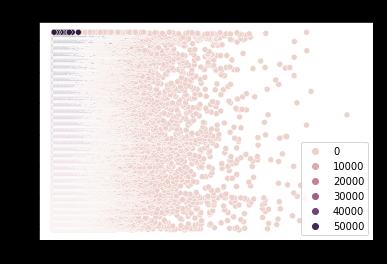
    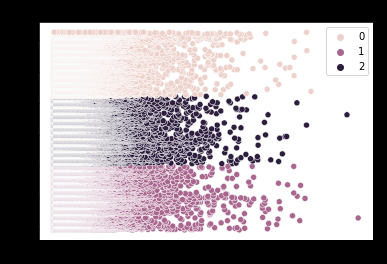
    
3. ¿Cómo podrías generar un forecast para el año 2016?, Y si tuvieras el forecast del 2016 ¿Cuánto dinero representaría la perdida por compensaciones de retraso?
    - Utilizamos un modelo de regresión que considera los datos de las aerolineas, las rutas y hora de despegue para predecir cuándo un vuelo tendrá un retraso
    
    - Depende del porcentaje de precisión estimado del modelo * el estimado de pérdidas (según tabla de costos propocionada: $ 27,359,750.00)
    
4. ¿A qué conclusiones ha llegado tu estudio?
    - No es muy evidente un comportamiento por fechas (utilizando todos los datos), posiblemente al separar por segmentos de fecha u otro parámetro (e.g. aerolinea o ruta) podríamos identificar algún patrón
    - Tomando en cuenta que algunas aerolíneas tienen compotramiento distinto de retrasos, así como que las rutas pueden representar comportamiento distintos unas con otras para las aeronaves, el modelo que utilizamos parece indicar que hay una relación que nos puede ayudar a predecir algunos retrasos.
    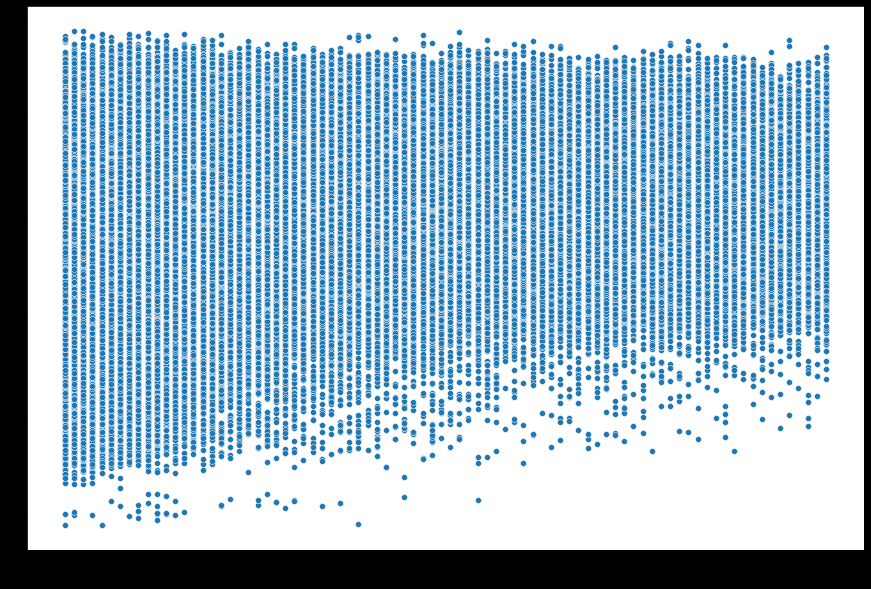
    
5. Justifica la técnica de modelado que has utilizado
    - Se utilizaron los modelos de regresión linear, Lasso y Ridge para evaluar el modelo (80% para train y 20% test)
    - El modelo usa algunos parámetros que parecen influenciar más según nuestra matriz de correlación:
    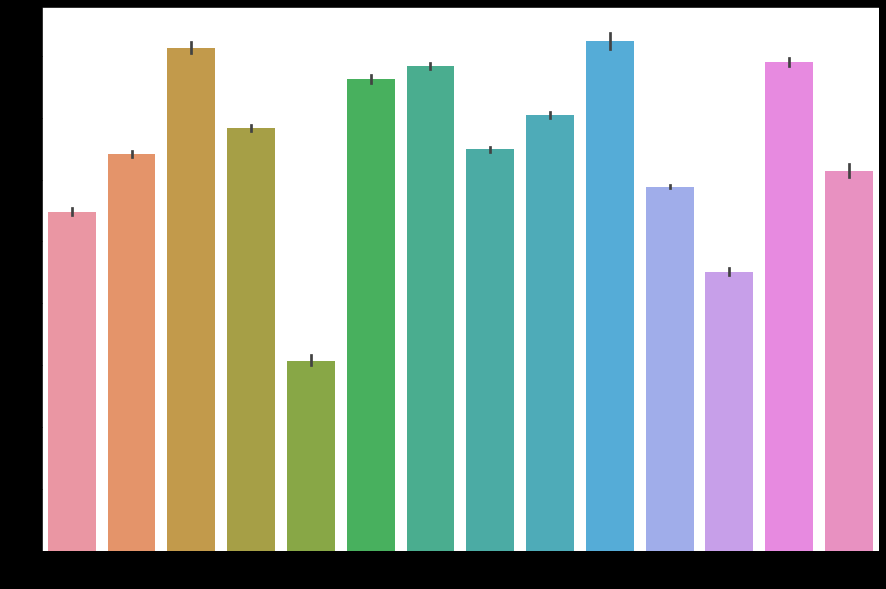
    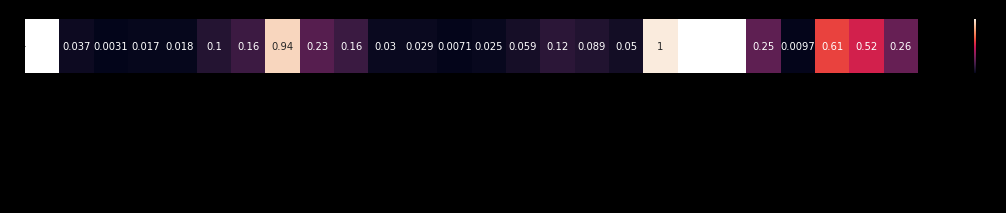

|Parámetros de interés|
|:-:|
|AIRLINE|
|ORIGIN_AIRPORT|
|DESTINATION_AIRPORT|
|SCHEDULED_DEPARTURE|

    - Para el modelado se quitaron outliers fuera del quantil 90
    
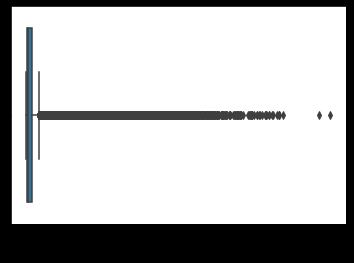
    
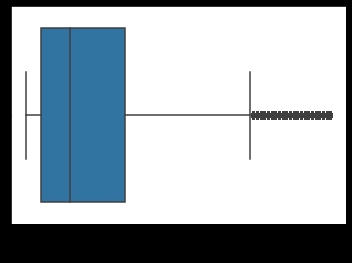
    
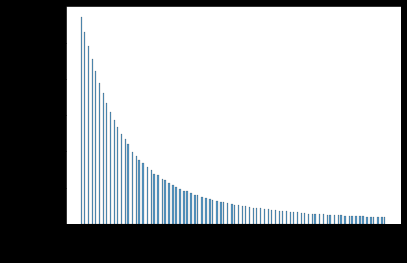
    
    
6. ¿Qué métrica de evaluación has utilizado? Y ¿Qué valores tiene?
    - Se utilizó el mean squared error (MSE) para comparar los valores predichos por el modelo y los valores del train set; para identificar que tan bien estaba modelando los retrasos el modelo.
    - El valor del modelo Ridge da un MSE de (%): 1.79
    
    
7. ¿Qué otro atributo te ayudaría a mejorar el desempeño de tu modelo, que actualmente no está en el conjunto de datos?
    - Contar con información del clima para los datos de vuelo podría ayudar a encontrar otros patrones de comportamiento útiles para el modelo que podrían represetnar retrasos.

__A continuación se muestra todo el desarrollo:__

In [5]:
# Añadir columna de fecha a partir de columnas year, month y day
dfdf.insert(0, 'DATE', pd.to_datetime(dfdf[['YEAR','MONTH', 'DAY']]))

In [6]:
date_delay = dfdf[['DATE', 'ARRIVAL_DELAY']]
date_delay['DATE'] = date_delay['DATE'].apply(lambda x: x.value)

C:\Users\jonat\AppData\Local\Temp\ipykernel_16392\1551662505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_delay['DATE'] = date_delay['DATE'].apply(lambda x: x.value)


<AxesSubplot:xlabel='DATE', ylabel='ARRIVAL_DELAY'>

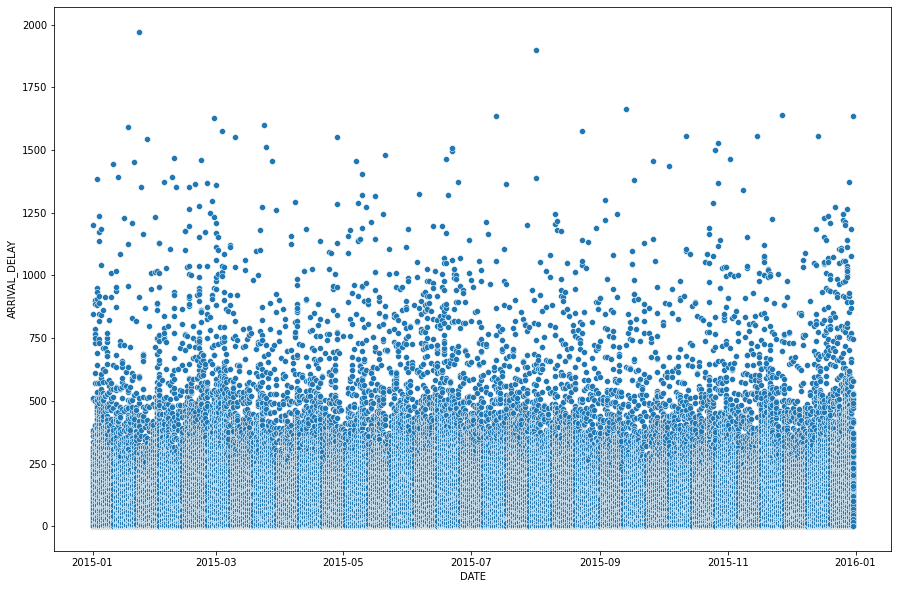

In [7]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=dfdf, x='DATE', y='ARRIVAL_DELAY')

C:\Users\jonat\anaconda3\envs\ds\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


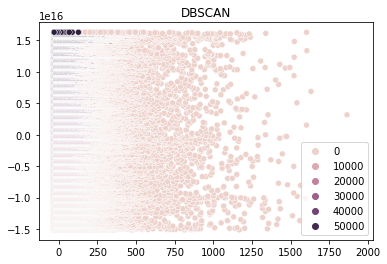

In [8]:
# Preparando X
X = date_delay.values

# Preparemos varios modelos de Agrupamiento
# from sklearn import cluster as C

modelos = [
    ('DBSCAN', C.DBSCAN(eps=0.95, min_samples=3)),
    ('MeanShift', C.MeanShift(bandwidth=2)),
    ('KMeans', C.KMeans(n_clusters=3))
]

# Entrenar Modelos
# for m in modelos:
#     m[1].fit(X)

modelos[0][1].fit(X)

# Ver resultados del Agrupamiento
# (Usemos un PCA de 2 dimensiones para proyectar las poblaciones a una grafica 2D)
# from sklearn.decomposition import PCA
X_2d = PCA(2).fit_transform(X)

# for m in modelos:    
#     sns.scatterplot(
#         data=None,
#         y=X_2d.T[0],
#         x=X_2d.T[1],
#         hue=m[1].labels_
#     )
#     plt.title( m[0] )
#     plt.show()

sns.scatterplot(
    data=None,
    y=X_2d.T[0],
    x=X_2d.T[1],
    hue=modelos[0][1].labels_
)
plt.title( modelos[0][0] )
plt.show()

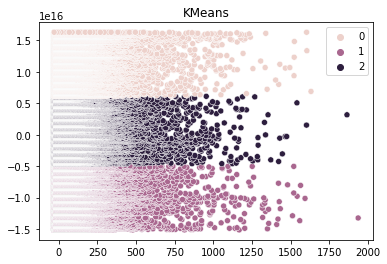

In [9]:
modelos[2][1].fit(X)

# Ver resultados del Agrupamiento
# (Usemos un PCA de 2 dimensiones para proyectar las poblaciones a una grafica 2D)
# from sklearn.decomposition import PCA
X_2d = PCA(2).fit_transform(X)

sns.scatterplot(
    data=None,
    y=X_2d.T[0],
    x=X_2d.T[1],
    hue=modelos[2][1].labels_
)
plt.title( modelos[2][0] )
plt.show()

AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64

<ul style="margin: 100px 0 100px; font-family: Arial; font-size: 20px">
        <li>Por fecha no parece haber un patrón</li>
        <li>Podemos observar en otros parámetros</li>
</ul>

<AxesSubplot:xlabel='AIRLINE', ylabel='ARRIVAL_DELAY'>

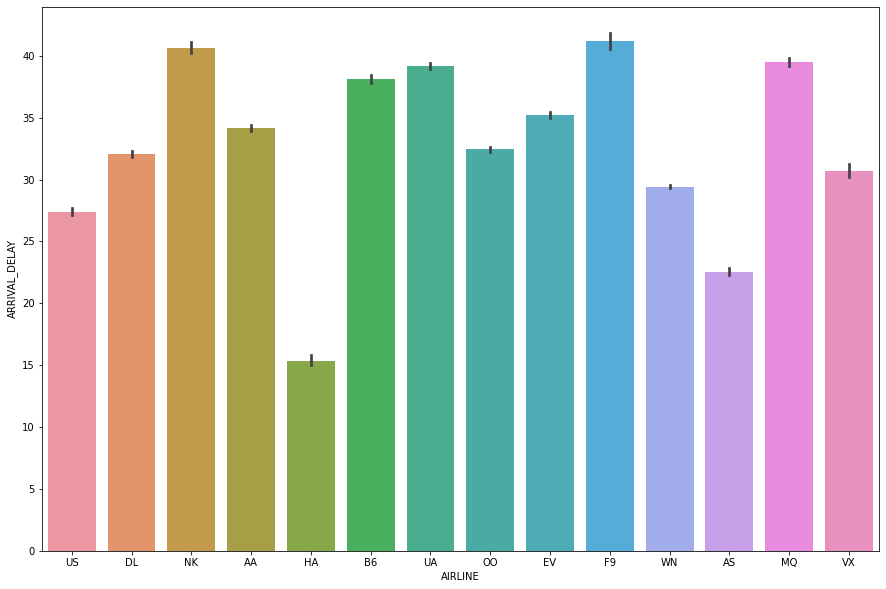

In [10]:
plt.figure(figsize=(15,10))
sns.barplot(x='AIRLINE',y='ARRIVAL_DELAY',data=dfdf, ci=95)

<AxesSubplot:>

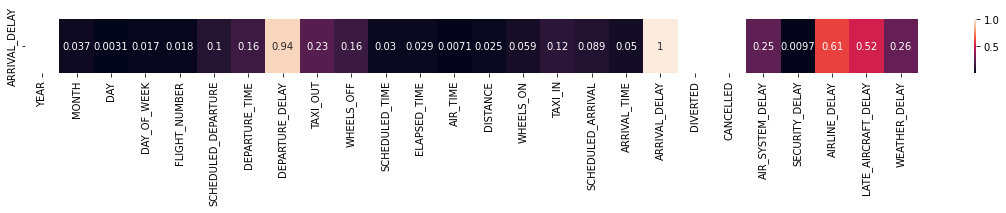

In [11]:
plt.figure(figsize=(20, 1))
sns.heatmap(pd.DataFrame(abs(fdf.corr()['ARRIVAL_DELAY'])).T, annot=True)

|Parámetros de interés|
|:-:|
|AIRLINE|
|ORIGIN_AIRPORT|
|DESTINATION_AIRPORT|
|SCHEDULED_DEPARTURE|
|DEPARTURE_TIME|

# Sin departure time (previo a operación)

|Parámetros de interés|
|:-:|
|AIRLINE|
|ORIGIN_AIRPORT|
|DESTINATION_AIRPORT|
|SCHEDULED_DEPARTURE|

In [12]:
# Target variables
tarv = ['DATE', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE']

## Regularizando

Filas antes de quitar outliers: 2086896


C:\Users\jonat\anaconda3\envs\ds\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


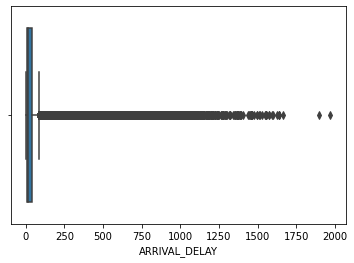

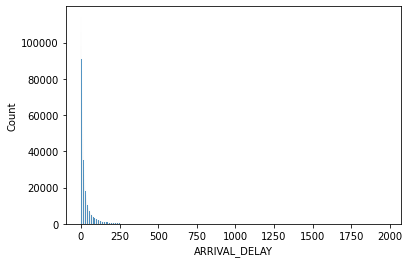

Filas despues de quitar outliers: 1880760


C:\Users\jonat\anaconda3\envs\ds\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


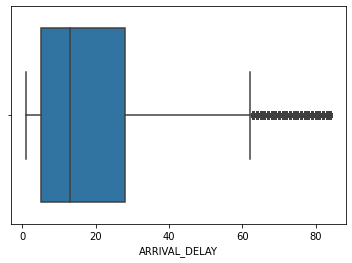

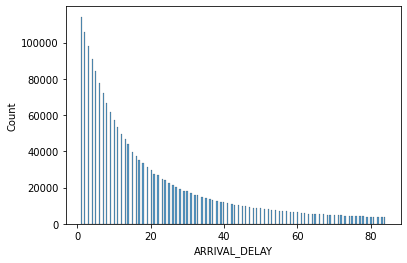

In [13]:
# Eliminar los outliers de Y (precio)

print('Filas antes de quitar outliers:', len(dfdf))
sns.boxplot(dfdf['ARRIVAL_DELAY'])
plt.show()
sns.histplot(dfdf['ARRIVAL_DELAY'])
plt.show()


dfdf = dfdf[ dfdf['ARRIVAL_DELAY'] <= dfdf['ARRIVAL_DELAY'].quantile(.90) ]

print('Filas despues de quitar outliers:', len(dfdf))
sns.boxplot( dfdf['ARRIVAL_DELAY'] )
plt.show()
sns.histplot( dfdf['ARRIVAL_DELAY'] )
plt.show()

In [14]:
X = dfdf[tarv]
y = dfdf['ARRIVAL_DELAY']

In [15]:
X['DATE'] = X['DATE'].apply(lambda x: x.value)

C:\Users\jonat\AppData\Local\Temp\ipykernel_16392\2878938863.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['DATE'] = X['DATE'].apply(lambda x: x.value)


In [16]:
# Codificando
static = pd.get_dummies(X.AIRLINE, X.ORIGIN_AIRPORT, X.DESTINATION_AIRPORT)
X = pd.concat([X, static], axis=1)
X.drop(['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'], axis=1, inplace=True)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

print('X entrenamiento (filas, columnas):', X_train.shape)
print('Y entrenamiento (filas, columnas):', y_train.shape)
print()
print('X prueba (filas, columnas):', X_test.shape)
print('Y prueba (filas, columnas):', y_test.shape)

X entrenamiento (filas, columnas): (1504608, 16)
Y entrenamiento (filas, columnas): (1504608,)

X prueba (filas, columnas): (376152, 16)
Y prueba (filas, columnas): (376152,)


In [20]:
from sklearn import linear_model as L
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

modelos = (
    ('Regresion', L.LinearRegression()),
    ('Lasso', L.Lasso()),
    ('Ridge', L.Ridge())
)

desempeños = []
for nombre, modelo in modelos:
    modelo.fit(X_train, y_train)
    y_hat = modelo.predict(X_test)
    desempeño = mean_absolute_percentage_error(y_test, y_hat)
    print(nombre, 'MSE (%):', desempeño)
    desempeños.append(desempeño)  

Regresion MSE (%): 2.7131827763689524
Lasso MSE (%): 2.7131629265689936
Ridge MSE (%): 2.683525229047435


C:\Users\jonat\anaconda3\envs\ds\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.09125e-39): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


C:\Users\jonat\anaconda3\envs\ds\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ARRIVAL_DELAY'>

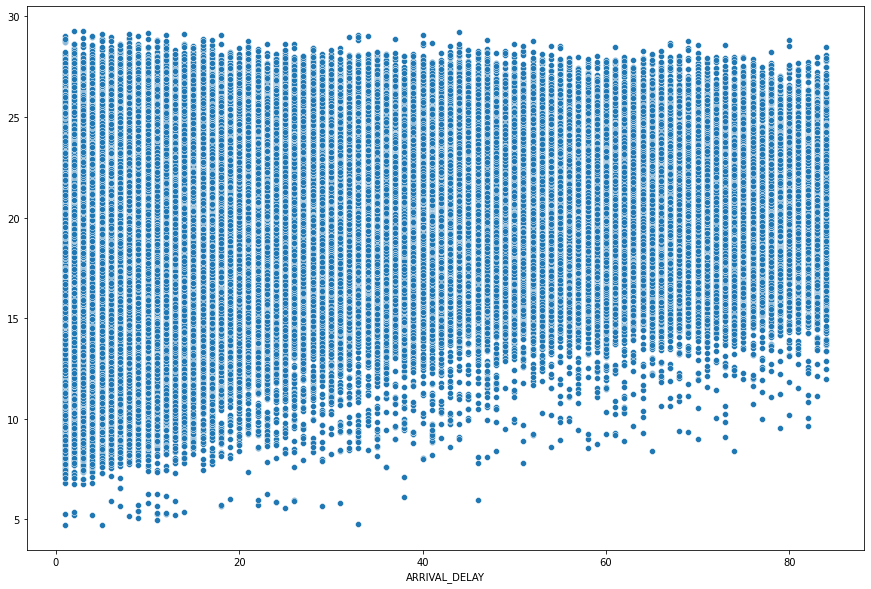

In [21]:
plt.figure(figsize=(15, 10))
sns.scatterplot(y_test, y_hat)

<ul style="margin: 100px 0 100px; font-family: Arial; font-size: 20px">
        <li>Sí contáramos con la información de: fecha, aerolínea, ruta, y hora de despegue, podríamos establecer si será un retraso con un 2.68% de error</li>
</ul>

## Costo calculado de los retrasos

In [4]:
def aircosts(num):
    return (1000, (500, (250, (100, (50, 0)[num<=15])[num<=30])[num<=60])[num<=120])[num<=180]

In [14]:
fdf['delay_costs'] = fdf['ARRIVAL_DELAY'].apply(lambda x: aircosts(x))

In [27]:
print(f"Total costs of 2015 delays are: ${fdf['delay_costs'].sum():20,.2f}")
print(f"Potential savings are: ${(100-desempeño) * fdf['delay_costs'].sum()/100:20,.2f}?")

Total costs of 2015 delays are: $      287,935,550.00
Potential savings are: $      280,208,726.87?


<p style="margin: 100px 0 100px; font-family: Arial; font-size: 20px">
        280.2 MUSD of savings
</p>
